# A VAE with Normalizing Flow

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from flows.flows import Flow, PlanarLayer

In [2]:
%matplotlib inline
plt.ioff()

PI = torch.Tensor([math.pi])

In [3]:
latent_dim = 10
dim = 784
K = 30  # Steps of flow

dev = torch.device('cuda')

# Load data
mnist_dataset = datasets.MNIST(tempfile.gettempdir(), train=True, download=True,
                       transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]))

In [4]:
def make_infernn(dim, latent_dim):
    encoder = nn.Sequential(
        nn.Linear(dim, 500),
        nn.Tanh(),
        nn.Linear(500, 2*latent_dim),
    )
    
    return encoder

In [5]:
def make_gennn(dim, latent_dim):
    decoder = nn.Sequential(
        nn.Linear(latent_dim, 500),
        nn.Tanh(),
        nn.Linear(500, dim),
        nn.Sigmoid(),
    )
    
    return decoder

In [6]:
def compute_reconstruction_error(x, x_p):
    return -torch.mean(torch.sum(x*torch.log(x_p) + (1.0-x)*torch.log(1.0-x_p), dim=1))

In [7]:
def compute_KL_divergence(mu, log_var):
    KL = -torch.mean(0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1))
    
    return KL

In [8]:
def make_flow(latent_dim, K):
        
    return Flow([PlanarLayer(latent_dim) for _ in range(K)])

In [9]:
fixed_z = np.random.randn(16, latent_dim)
fixed_z = torch.Tensor(fixed_z).to(dev)
def sample_digits(model, flow):
    imas = model(flow(fixed_z)[0][-1]).detach().cpu().numpy()
    imas = imas.reshape([16, 28, 28])
    return imas

In [10]:
def create_animation_digits(intermediate_results):
    
    fig, ax_arr = plt.subplots(4, 4, figsize=(12, 12))
    
    imas = intermediate_results[0]
    plots = 16*[0]
    
    for i in range(16):
        plots[i] = ax_arr[i//4, i%4].imshow(imas[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax_arr[i//4, i%4].axis('off')
    
    
    def update_scat(i):
        imas = intermediate_results[i]
        for i in range(16):
            plots[i].set_data(imas[i])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [11]:
def sample_prior(n):
    z = torch.randn(n, latent_dim)
    return z

In [12]:
def sample_posterior(decoder, flow, n):
    z = sample_prior(n)
    return decoder(flow(z)[0][-1])

## Build and train VAE

In [21]:
batch_size=200
epochs = 50

train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [22]:
encoder = make_infernn(dim, latent_dim).to(dev)
decoder = make_gennn(dim, latent_dim).to(dev)
flow = make_flow(latent_dim, K).to(dev)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(flow.parameters()), lr=1e-3)

In [23]:
loss = []
KL = []
RE = []

intermediate_results = []

In [24]:
# Train loop
t0 = time.time()

encoder.to(dev)
decoder.to(dev)
flow.to(dev)

for e in range(epochs):

    cum_loss = 0
    cum_RE = 0
    cum_KL = 0
    count = 0
    
    for images, _ in train_loader:
        images = images.view(images.shape[0], -1)
        images = images.to(dev, non_blocking=True)

        optimizer.zero_grad()

        infer = encoder(images)
        mu, log_var = infer[:, :latent_dim], infer[:, latent_dim:]
        
        z0 = mu + torch.sqrt(torch.exp(log_var)) * torch.randn_like(mu)
        zs, log_det = flow(z0)
        zk = zs[-1]
        
        x_p = decoder(zk)
        
        _RE = compute_reconstruction_error(images, x_p)
        _KL = compute_KL_divergence(mu, log_var)
        
        _loss = _RE + _KL - torch.mean(log_det)

        cum_loss += _loss.item()
        cum_RE += _RE.item()
        cum_KL += _KL.item()
        count += 1

        _loss.backward()
        optimizer.step()

    loss.append(cum_loss/count)
    KL.append(cum_KL/count)
    RE.append(cum_RE/count)
    intermediate_results.append(sample_digits(decoder, flow))
        
    if e%5 == 4:
        print('epoch: {}, at time: {:.2f}, loss: {:.3e}, RE: {:.3e}, KL: {:.3e}'.format(
              e, time.time()-t0, loss[-1], RE[-1], KL[-1]), end='\r')

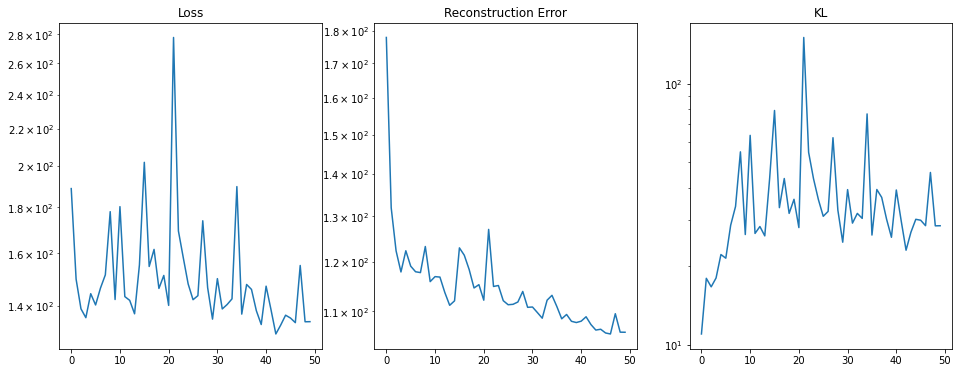

In [25]:
fig, ax_arr = plt.subplots(1, 3, figsize=(16, 6))

ax_arr[0].plot(loss)
ax_arr[0].set_yscale('log')
ax_arr[0].set_title('Loss')


ax_arr[1].plot(RE)
ax_arr[1].set_yscale('log')
ax_arr[1].set_title('Reconstruction Error')


ax_arr[2].plot(KL)
ax_arr[2].set_yscale('log')
ax_arr[2].set_title('KL')

plt.show()

In [26]:
ani = create_animation_digits(intermediate_results)

In [29]:
HTML(ani.to_html5_video())

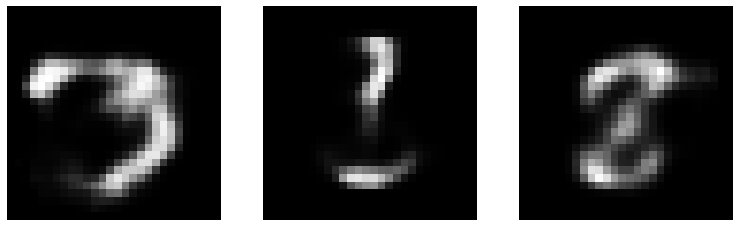

In [28]:
imas = sample_posterior(decoder.cpu(), flow.cpu(), 3).detach().cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

ax[0].imshow(np.reshape(imas[0], [28, 28]), cmap='gray')
ax[0].axis('off')

ax[1].imshow(np.reshape(imas[1], [28, 28]), cmap='gray')
ax[1].axis('off')

ax[2].imshow(np.reshape(imas[2], [28, 28]), cmap='gray')
ax[2].axis('off')

plt.show()